In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

## Bring in the data

In [3]:
tropnames = {'etnakhta': u'\u0591', 'segol': u'\u0592', 'shalshelet': u'\u0593', 'katan': u'\u0594', 'gadol': u'\u0595',
             'tipkha': u'\u0596', 'revii': u'\u0597', 'tsinnorit': u'\u0598', 'pashta': u'\u0599', 'yetiv': u'\u059a', 'tevir': u'\u059b',
             'geresh': u'\u059c', 'gereshmukdam': u'\u059d', 'gershayim': u'\u059e', 'karnepara': u'\u059f', 'telishagedola': u'\u05a0',
             'pazer': u'\u05a1', 'munakh': u'\u05a3', 'mapakh': u'\u05a4', 'merkha': u'\u05a5',
             'merkhakfula': u'\u05a6', 'darga': u'\u05a7', 'kadma': u'\u05a8', 'telishaketana': u'\u05a9', 'yerakhbenyomo': u'\u05aa',
             'sofpasuk': u'\u05c3', 'zarka': u'\u05ae'}

# per wikipedia: Note that both marks have been wrongly named by Unicode.[5][6] Zarqa/tsinnor corresponds to Unicode
# "Hebrew accent zinor", code point U+05AE (where "zinor" is a misspelled form for tsinnor), while tsinnorit maps to
# "Hebrew accent zarqa", code point U+0598. 

In [4]:
sfarim = ['bereshit', 'shmot', 'vayikra', 'bmidbar', 'dvarim']

counts = {}
for sefer in sfarim:
    counts[sefer] = {}
    tree = ET.parse(sefer + '.xml')
    root = tree.getroot() 
    prakim = root.findall('.//c')
    for perek in prakim:
        pereknum = int(perek.attrib['n'])
        if pereknum not in counts[sefer]: counts[sefer][pereknum] = {}
        psukim = perek.findall('v')
        for pasuk in psukim:
            pasuknum = int(pasuk.attrib['n'])
            if pasuknum not in counts[sefer][pereknum]:
                row = {name: 0 for name in tropnames.keys()}
                row['sefer'] = sefer
                row['pasuk'] = pasuknum
                row['perek'] = pereknum
                counts[sefer][pereknum][pasuknum] = row
            words = pasuk.findall('w')
            if 'wordcount' not in counts[sefer][pereknum][pasuknum]:
                counts[sefer][pereknum][pasuknum]['wordcount'] = len(words)
            else:
                counts[sefer][pereknum][pasuknum]['wordcount'] += len(words)
            for wordobj in words:
                word = wordobj.text
                for trop in tropnames:
                    if tropnames[trop] in word: # if there is ever the same trop more than once on one word, it won't be captured here
                        counts[sefer][pereknum][pasuknum][trop] += 1

In [5]:
flatcounts = [counts[s][pe][pa] for s in counts for pe in counts[s] for pa in counts[s][pe]]
df = pd.DataFrame(flatcounts)
df.set_index(['sefer', 'perek', 'pasuk'], inplace=True)
df = df.reindex(sfarim, level=0)

In [6]:
# for pretty plot labels
seferticklocs = [0,df.index.get_loc(('shmot',1,1)),df.index.get_loc(('vayikra',1,1)),df.index.get_loc(('bmidbar',1,1)),df.index.get_loc(('dvarim',1,1))]
seferlabels = ['Bereshit', 'Shmot', 'Vayikra', 'Bamidbar', 'D\'varim']

## Aggregate to inspect by sefer and perek

In [7]:
sefergroup = df.groupby(level=['sefer'])
sefermeans = sefergroup.mean()
sefersums = sefergroup.sum()

In [8]:
# I didn't end up using these, but they're here
perekgroup = df.groupby(level=['sefer','perek'], sort=False)
perekmeans = perekgroup.mean()
perekmeans = perekmeans.reindex(sfarim, level=0) # sort=False isn't working, so...
perekmeans.dropna(inplace=True) # workaround for https://github.com/pydata/pandas/issues/9344
pereksums = perekgroup.sum()
pereksums = pereksums.reindex(sfarim, level=0) # sort=False isn't working, so...
pereksums.dropna(inplace=True) # workaround for https://github.com/pydata/pandas/issues/9344

## Telishas

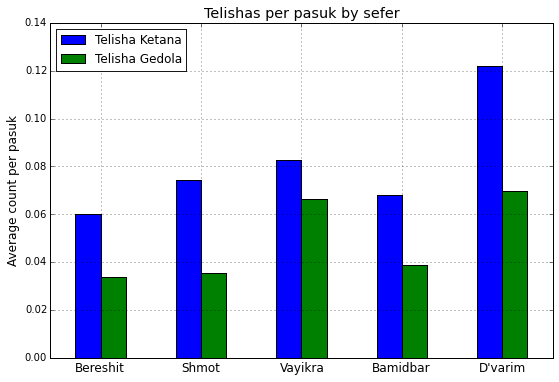

In [9]:
ax = sefermeans[['telishaketana','telishagedola']].plot(by='sefer', kind='bar', figsize=(9,6)) # 'shalshelet', 'merkhakfula'
plt.xticks(range(5), seferlabels, fontsize='large', rotation=0)
plt.title('Telishas per pasuk by sefer', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Telisha Ketana','Telisha Gedola'], loc='upper left', framealpha=0.9)

plt.savefig('telisha_bar.svg', transparent=True)

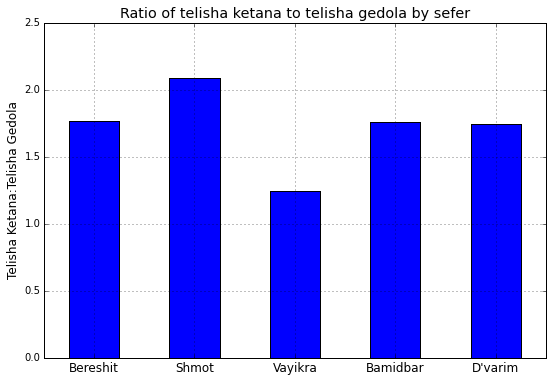

In [10]:
(sefermeans['telishaketana']/sefermeans['telishagedola']).plot(kind='bar', figsize=(9,6))
plt.xticks(range(5), seferlabels, fontsize='large', rotation=0)
plt.title('Ratio of telisha ketana to telisha gedola by sefer', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Telisha Ketana:Telisha Gedola', fontsize='large')

plt.savefig('telisha_ratios.svg', transparent=True)

## Moving average plots

In [11]:
rolling = pd.rolling_mean(df, 500, center=True)

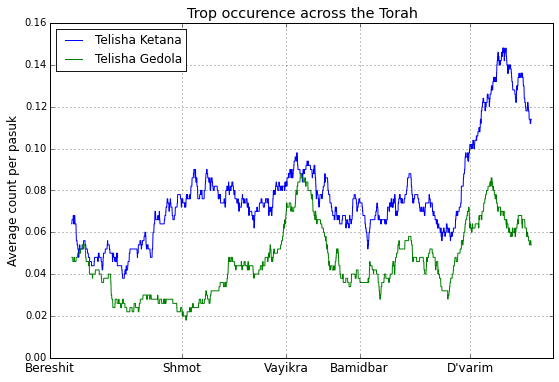

In [12]:
rolling.plot(y=['telishaketana', 'telishagedola'], figsize=(9,6))
plt.xticks(seferticklocs, seferlabels, fontsize='large')
plt.title('Trop occurence across the Torah', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
plt.legend(['Telisha Ketana', 'Telisha Gedola'], loc='upper left', framealpha=0.9)

plt.savefig('telisha.svg', transparent=True)

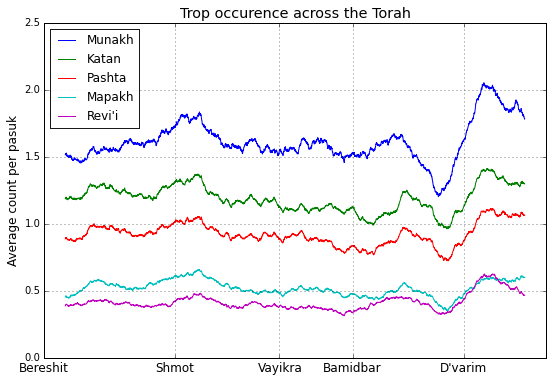

In [13]:
rolling.plot(y=['munakh', 'katan', 'pashta', 'mapakh', 'revii'], figsize=(9,6))
plt.xticks(seferticklocs, seferlabels, fontsize='large')
plt.title('Trop occurence across the Torah', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
plt.legend(['Munakh', 'Katan', 'Pashta', 'Mapakh', 'Revi\'i'], loc='upper left', framealpha=0.9)

plt.savefig('common_trop.svg', transparent=True)

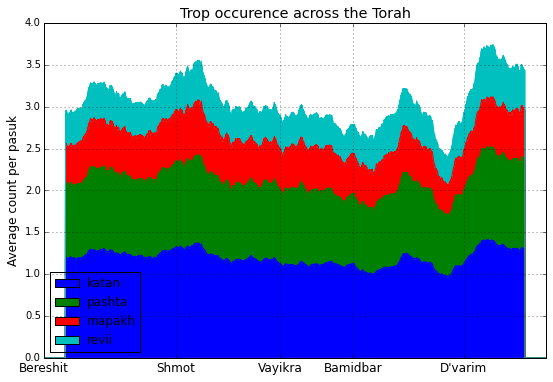

In [14]:
# trying to make an area plot to see how all these compare to the total number of munakhs.

rolling.plot(y=['katan', 'pashta', 'mapakh', 'revii'], kind='area', figsize=(9,6))
# plt.hold(True)
# rolling.plot(y=['munakh'])
plt.xticks(seferticklocs, seferlabels, fontsize='large')
plt.title('Trop occurence across the Torah', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
# plt.legend(['Katan', 'Pashta', 'Mapakh', 'Revi\'i'], loc='upper left', framealpha=0.9)
# plt.savefig('common_trop.svg', transparent=True)

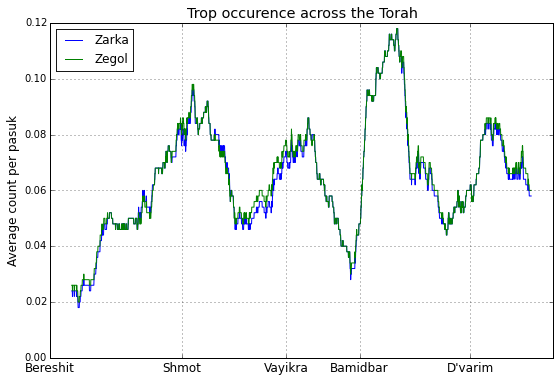

In [15]:
rolling.plot(y=['zarka', 'segol'], figsize=(9,6))
plt.xticks(seferticklocs, seferlabels, fontsize='large')
plt.title('Trop occurence across the Torah', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
plt.legend(['Zarka', 'Zegol'], loc='upper left', framealpha=0.9)

plt.savefig('zarkasegol.svg', transparent=True)

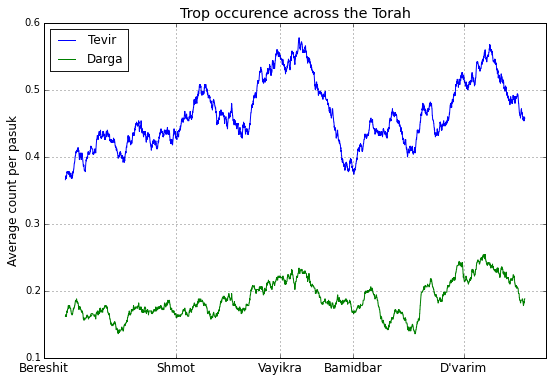

In [16]:
rolling.plot(y=['tevir', 'darga'], figsize=(9,6))
plt.xticks(seferticklocs, seferlabels, fontsize='large')
plt.title('Trop occurence across the Torah', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
plt.legend(['Tevir', 'Darga'], loc='upper left', framealpha=0.9)

plt.savefig('dargatevir.svg', transparent=True)

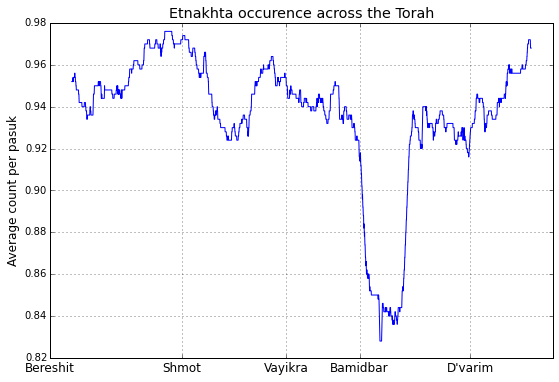

In [17]:
rolling.plot(y=['etnakhta'], figsize=(9,6), legend=False)
plt.xticks(seferticklocs, seferlabels, fontsize='large')
plt.title('Etnakhta occurence across the Torah', fontsize='x-large')
plt.xlabel('')
plt.ylabel('Average count per pasuk', fontsize='large')
# plt.legend(['Tevir', 'Darga'], loc='upper left', framealpha=0.9)

plt.savefig('etnakhta.svg', transparent=True)

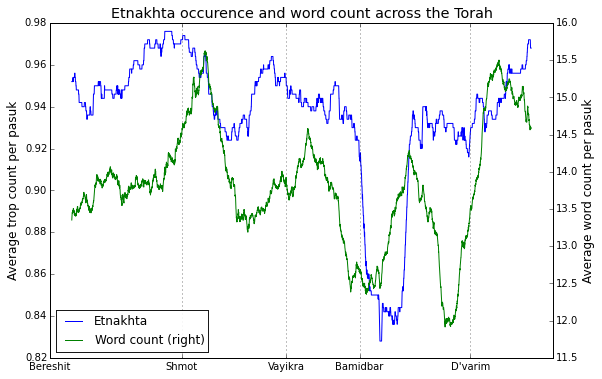

In [18]:
ax = rolling[['etnakhta', 'wordcount']].plot(secondary_y=['wordcount'], figsize=(9,6), legend=False)
plt.xticks(seferticklocs, seferlabels, fontsize='large') # this doesn't seem to be setting the font size
ax.grid(axis='x')
ax.set_title('Etnakhta occurence and word count across the Torah', fontsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('Average trop count per pasuk', fontsize='large')
ax.right_ax.set_ylabel('Average word count per pasuk', fontsize='large')
plt.legend((ax.get_lines()[0], ax.right_ax.get_lines()[0]), ['Etnakhta', 'Word count (right)'], loc='lower left', framealpha=0.9)

plt.savefig('etnakhtawordcount.svg', transparent=True)

## Correlation tables

In [19]:
dfforcorrs = df.drop('wordcount',1)

In [20]:
dfforcorrs.corr().to_csv('rawcorr.csv')

In [21]:
rollingforcorrs = pd.rolling_mean(dfforcorrs, 500, center=True)
rollingforcorrs.corr().to_csv('rollingcorr.csv')

## Looking for anomolies

In [22]:
df.loc['bmidbar'].query('etnakhta == 0')[['etnakhta']]

etnakhta
perek pasuk          
1     6             0
      7             0
      8             0
      9             0
      11            0
      12            0
      13            0
      14            0
      15            0
      48            0
2     1             0
3     5             0
      11            0
      14            0
      44            0
4     1             0
      17            0
      20            0
      21            0
5     1             0
      5             0
      9             0
      11            0
6     1             0
      22            0
      24            0
      25            0
      26            0
7     4             0
      14            0
...               ...
26    11            0
      46            0
      52            0
      53            0
27    5             0
      6             0
      15            0
28    1             0
29    18            0
      21            0
      24            0
      27            0
      30            0
      33            0
      37            0
31    1             0
      25            0
      33            0
      34            0
      44            0
      45            0
      46            0
      53            0
32    35            0
33    56            0
34    1             0
      16            0
      20            0
      21            0
35    9             0

[138 rows x 1 columns]

In [23]:
# this seems to occur when there's a k'tiv/kri on the last word of a pasuk.
df.query('sofpasuk == 0')[['sofpasuk']]

sofpasuk
sefer    perek pasuk          
bereshit 27    3             0
         43    28            0
         49    11            0
shmot    2     5             0
         14    25            0
               29            0
         20    3             0
               4             0
               8             0
               9             0
               10            0
         34    6             0
         37    8             0
vayikra  18    17            0
         19    1             0
         26    7             0
bmidbar  7     32            0
               40            0
               55            0
               68            0
         25    19            0
dvarim   5     10            0
               12            0
         6     4             0
         9     20            0
         22    20            0
         25    9             0

In [24]:
df.query('tsinnorit > 0')[['tsinnorit']]

tsinnorit
sefer    perek pasuk           
bereshit 17    20             1
         47    29             1
shmot    6     6              1
         30    12             1
         36    2              1
vayikra  4     2              1
         20    2              1
bmidbar  20    19             1
dvarim   14    24             1
         31    7              1

## Histograms and other plots

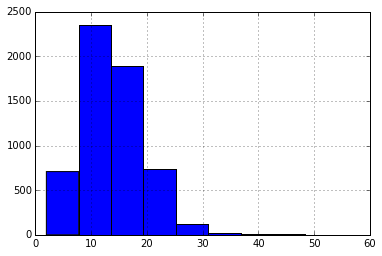

In [25]:
df['wordcount'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1089e6890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1087e7e90>]], dtype=object)

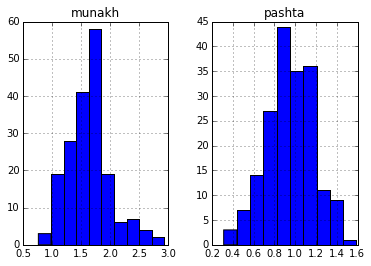

In [26]:
perekmeans[['munakh','pashta']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108a6c7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10978b1d0>]], dtype=object)

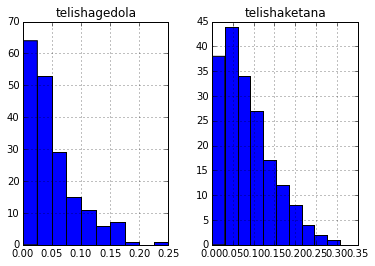

In [27]:
perekmeans[['telishaketana','telishagedola']].hist()

In [28]:
# this is a little off from https://en.wikipedia.org/wiki/Munach#Total_occurrences
sum(df['munakh'])

9451

## Output to CSV

In [29]:
df.to_csv('trop.csv')